In [119]:
import mne
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
import pandas as pd
import seaborn as sns
import os
from datetime import datetime

In [108]:
class EEGSpeedClassifier(nn.Module):
    def __init__(self, input_channels, num_samples_per_epoch, num_classes):
        super(EEGSpeedClassifier, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.2)
        
        # Fully Connected Layers
        self.flatten_size = self._calculate_flatten_size(input_channels, num_samples_per_epoch)
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def _calculate_flatten_size(self, input_channels, num_samples):
        x = torch.zeros(1, input_channels, num_samples)
        x = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2(F.relu(self.conv2(x))))
        return x.numel()
    
    def forward(self, x):
        # First Convolutional Block
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second Convolutional Block
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Fully Connected Layers
        x = torch.flatten(x, 1)  
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc1(x)
        x = self.fc2(x)
        return x

In [107]:
# function extracts segments and labels from one file
def preprocess_eeg(file_path, label, segment_length=2, step_size=0.5):
    # Load the raw EEG data
    raw_data = mne.io.read_raw_bdf(file_path, preload=True)
    
    # Apply a 1 Hz high-pass filter
    raw_data.filter(l_freq=1.0, h_freq=None, fir_design='firwin')
    
    # Segment the data based on segment length (seconds) and overlap %
    sfreq = raw_data.info['sfreq']  # Sampling frequency
    segment_samples = int(segment_length * sfreq)
    step_samples = int(step_size * sfreq)
    
    # Create segments
    segments = []
    labels = []
    for start in range(0, len(raw_data) - segment_samples, step_samples):
        segment = raw_data[:, start:start + segment_samples][0]
        segments.append(segment)
        labels.append(label)
    
    segments = np.array(segments)
    labels = np.array(labels)
    
    # Normalize: Normalize the EEG 
    scaler = StandardScaler()
    segments = np.array([scaler.fit_transform(segment.T).T for segment in segments])
    
    return segments, labels



In [63]:
def train_and_test(model, device, train_subset, test_subset, criterion, optimizer, fold, k_folds=3, learning_rate=0.0001, num_epochs=100):
    model.to(device)
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

    print(f'Training samples: {len(train_subset)}, Testing samples: {len(test_subset)}')
    
    # Training and evaluation loop
    train_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Fold {fold+1}, Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Compute accuracy
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    test_loss /= total
    accuracy = correct / total * 100

    print(f"Fold {fold+1} / {k_folds}, "
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {train_loss:.4f}, "
        f"Test Loss: {test_loss:.4f}",
        f"Accuracy: {accuracy:.2f}%")
    
    return model, train_losses, test_loss, accuracy

In [76]:
# all_segments shape: (1473, 129, 1024)
# all_labels shape: (1473,)

# List of file paths and corresponding labels
file_paths = [
    r'D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_050.bdf',
    r'D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf',
    r'D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf',
    r'D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf'
]

labels = [0.5, 0.75, 1.0, 1.25]

label_mapping = {0.5: 0, 0.75: 1, 1.0: 2, 1.25: 3}
reverse_mapping = {v: k for k, v in label_mapping.items()}  # For interpreting results later

# Define parameters to test
window_sizes = [0.5, 1.0, 1.5, 2.0]  # seconds
step_sizes = [0.5, 1.0, 1.5, 2.0]    # percent overlap

# Create results storage
results = {
    'window_size': [],
    'step_size': [],
    'train_loss': [],
    'test_loss': [],
    'accuracy': [],
    'f1': []
    }

In [110]:
def get_segments_and_labels(file_paths, labels, window_size, step_size):
    all_segments = []
    all_labels = []

    for file_path, label in zip(file_paths, labels):
        segments, segment_labels = preprocess_eeg(file_path, label, segment_length=window_size, step_size=step_size)
        all_segments.append(segments)
        all_labels.append(segment_labels)

    all_segments = np.concatenate(all_segments, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    print(all_segments.shape, all_labels.shape)

    return all_segments, all_labels

In [62]:
def run_experiment(window_size, step_size):
    all_segments, all_mapped_labels = get_segments_and_labels(file_paths, labels, window_size, step_size)
    
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(all_segments, dtype=torch.float32)
    y_tensor = torch.tensor(all_mapped_labels, dtype=torch.float32)

    # Create a single dataset from features (X_tensor) and labels (y_tensor)
    dataset = TensorDataset(X_tensor, y_tensor)

    # Define 3-fold cross validation
    k_folds = 3
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    input_channels = 129  # Number of EEG channels
    num_samples_per_segment = all_segments.shape[2]  # Number of samples in one segment
    num_classes = 4  # 0.5, 0.75, 1, 1.25 m/s

    model = EEGSpeedClassifier(input_channels, num_samples_per_segment, num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    num_epochs = 100

    # Loop over the 3 folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):  

        # Reinitialize model for each fold
        model = EEGSpeedClassifier(input_channels, num_samples_per_segment, num_classes)

        # Reinitialize optimizer for each fold
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

        # Create train and test subsets for this fold
        train_subset = Subset(dataset, train_idx.tolist())
        test_subset = Subset(dataset, test_idx.tolist())

        # Train and test the model
        trained_model, train_loss, test_loss, accuracy = train_and_test(model, device, train_subset, test_subset, criterion, optimizer, fold, num_epochs=num_epochs)

        # Save model
        model_path = f'models/model_w{window_size}_s{step_size}_f{fold}.pt'
        torch.save(trained_model.state_dict(), model_path)
        
        # Store results
        results['window_size'].append(window_size)
        results['step_size'].append(step_size)
        results['train_loss'].append(train_loss)
        results['test_loss'].append(test_loss)
        results['accuracy'].append(accuracy)
        

In [111]:
# run all combinations of window and step size
for window_size in window_sizes:
    for step_size in step_sizes:
        print(f"window size={window_size}, step size={step_size}")
        run_experiment(window_size, step_size)

window size=0.5, step size=0.5
Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_050.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 200191  =      0.000 ...   390.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


(2958, 129, 256) (2958,)
Training samples: 1972, Testing samples: 986
Fold 1, Epoch 1/100, Train Loss: 0.1947
Fold 1, Epoch 11/100, Train Loss: 0.0003
Fold 1, Epoch 21/100, Train Loss: 0.0001
Fold 1, Epoch 31/100, Train Loss: 0.0000
Fold 1, Epoch 41/100, Train Loss: 0.0000
Fold 1, Epoch 51/100, Train Loss: 0.0000
Fold 1, Epoch 61/100, Train Loss: 0.0000
Fold 1, Epoch 71/100, Train Loss: 0.0000
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0019 Accuracy: 99.90%
Training samples: 1972, Testing samples: 986
Fold 2, Epoch 1/100, Train Loss: 0.2401
Fold 2, Epoch 11/100, Train Loss: 0.0003
Fold 2, Epoch 21/100, Train Loss: 0.0001
Fold 2, Epoch 31/100, Train Loss: 0.0000
Fold 2, Epoch 41/100, Train Loss: 0.0000
Fold 2, Epoch 51/100, Train Loss: 0.0000
Fold 2, Epoch 61/100, Train Loss: 0.0000
Fold 2, Epoch 71/100, Train Loss: 0.0000
Fold 2, Epoch 81/100, T

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


(1481, 129, 256) (1481,)
Training samples: 987, Testing samples: 494
Fold 1, Epoch 1/100, Train Loss: 0.4599
Fold 1, Epoch 11/100, Train Loss: 0.0010
Fold 1, Epoch 21/100, Train Loss: 0.0004
Fold 1, Epoch 31/100, Train Loss: 0.0002
Fold 1, Epoch 41/100, Train Loss: 0.0001
Fold 1, Epoch 51/100, Train Loss: 0.0001
Fold 1, Epoch 61/100, Train Loss: 0.0001
Fold 1, Epoch 71/100, Train Loss: 0.0000
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0016 Accuracy: 100.00%
Training samples: 987, Testing samples: 494
Fold 2, Epoch 1/100, Train Loss: 0.3144
Fold 2, Epoch 11/100, Train Loss: 0.0007
Fold 2, Epoch 21/100, Train Loss: 0.0002
Fold 2, Epoch 31/100, Train Loss: 0.0001
Fold 2, Epoch 41/100, Train Loss: 0.0001
Fold 2, Epoch 51/100, Train Loss: 0.0000
Fold 2, Epoch 61/100, Train Loss: 0.0000
Fold 2, Epoch 71/100, Train Loss: 0.0000
Fold 2, Epoch 81/100, Tr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


(987, 129, 256) (987,)
Training samples: 658, Testing samples: 329
Fold 1, Epoch 1/100, Train Loss: 0.4964
Fold 1, Epoch 11/100, Train Loss: 0.0015
Fold 1, Epoch 21/100, Train Loss: 0.0004
Fold 1, Epoch 31/100, Train Loss: 0.0003
Fold 1, Epoch 41/100, Train Loss: 0.0002
Fold 1, Epoch 51/100, Train Loss: 0.0001
Fold 1, Epoch 61/100, Train Loss: 0.0001
Fold 1, Epoch 71/100, Train Loss: 0.0000
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0001
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0057 Accuracy: 100.00%
Training samples: 658, Testing samples: 329
Fold 2, Epoch 1/100, Train Loss: 0.4828
Fold 2, Epoch 11/100, Train Loss: 0.0016
Fold 2, Epoch 21/100, Train Loss: 0.0005
Fold 2, Epoch 31/100, Train Loss: 0.0003
Fold 2, Epoch 41/100, Train Loss: 0.0001
Fold 2, Epoch 51/100, Train Loss: 0.0001
Fold 2, Epoch 61/100, Train Loss: 0.0001
Fold 2, Epoch 71/100, Train Loss: 0.0001
Fold 2, Epoch 81/100, Trai

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


(742, 129, 256) (742,)
Training samples: 494, Testing samples: 248
Fold 1, Epoch 1/100, Train Loss: 0.8095
Fold 1, Epoch 11/100, Train Loss: 0.0027
Fold 1, Epoch 21/100, Train Loss: 0.0010
Fold 1, Epoch 31/100, Train Loss: 0.0006
Fold 1, Epoch 41/100, Train Loss: 0.0004
Fold 1, Epoch 51/100, Train Loss: 0.0002
Fold 1, Epoch 61/100, Train Loss: 0.0001
Fold 1, Epoch 71/100, Train Loss: 0.0001
Fold 1, Epoch 81/100, Train Loss: 0.0001
Fold 1, Epoch 91/100, Train Loss: 0.0001
Fold 1, Epoch 100/100, Train Loss: 0.0001
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0001, Test Loss: 0.0053 Accuracy: 98.79%
Training samples: 495, Testing samples: 247
Fold 2, Epoch 1/100, Train Loss: 0.6363
Fold 2, Epoch 11/100, Train Loss: 0.0023
Fold 2, Epoch 21/100, Train Loss: 0.0007
Fold 2, Epoch 31/100, Train Loss: 0.0004
Fold 2, Epoch 41/100, Train Loss: 0.0002
Fold 2, Epoch 51/100, Train Loss: 0.0002
Fold 2, Epoch 61/100, Train Loss: 0.0001
Fold 2, Epoch 71/100, Train Loss: 0.0001
Fold 2, Epoch 81/100, Train

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


(2954, 129, 512) (2954,)
Training samples: 1969, Testing samples: 985
Fold 1, Epoch 1/100, Train Loss: 0.1211
Fold 1, Epoch 11/100, Train Loss: 0.0001
Fold 1, Epoch 21/100, Train Loss: 0.0001
Fold 1, Epoch 31/100, Train Loss: 0.0000
Fold 1, Epoch 41/100, Train Loss: 0.0000
Fold 1, Epoch 51/100, Train Loss: 0.0000
Fold 1, Epoch 61/100, Train Loss: 0.0000
Fold 1, Epoch 71/100, Train Loss: 0.0000
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0039 Accuracy: 99.39%
Training samples: 1969, Testing samples: 985
Fold 2, Epoch 1/100, Train Loss: 0.1030
Fold 2, Epoch 11/100, Train Loss: 0.0001
Fold 2, Epoch 21/100, Train Loss: 0.0000
Fold 2, Epoch 31/100, Train Loss: 0.0000
Fold 2, Epoch 41/100, Train Loss: 0.0000
Fold 2, Epoch 51/100, Train Loss: 0.0000
Fold 2, Epoch 61/100, Train Loss: 0.0000
Fold 2, Epoch 71/100, Train Loss: 0.0000
Fold 2, Epoch 81/100, T

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


(1477, 129, 512) (1477,)
Training samples: 984, Testing samples: 493
Fold 1, Epoch 1/100, Train Loss: 0.2150
Fold 1, Epoch 11/100, Train Loss: 0.0003
Fold 1, Epoch 21/100, Train Loss: 0.0001
Fold 1, Epoch 31/100, Train Loss: 0.0001
Fold 1, Epoch 41/100, Train Loss: 0.0000
Fold 1, Epoch 51/100, Train Loss: 0.0000
Fold 1, Epoch 61/100, Train Loss: 0.0000
Fold 1, Epoch 71/100, Train Loss: 0.0000
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0056 Accuracy: 98.38%
Training samples: 985, Testing samples: 492
Fold 2, Epoch 1/100, Train Loss: 0.2713
Fold 2, Epoch 11/100, Train Loss: 0.0005
Fold 2, Epoch 21/100, Train Loss: 0.0001
Fold 2, Epoch 31/100, Train Loss: 0.0001
Fold 2, Epoch 41/100, Train Loss: 0.0000
Fold 2, Epoch 51/100, Train Loss: 0.0000
Fold 2, Epoch 61/100, Train Loss: 0.0000
Fold 2, Epoch 71/100, Train Loss: 0.0000
Fold 2, Epoch 81/100, Tra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


(986, 129, 512) (986,)
Training samples: 657, Testing samples: 329
Fold 1, Epoch 1/100, Train Loss: 0.3485
Fold 1, Epoch 11/100, Train Loss: 0.0011
Fold 1, Epoch 21/100, Train Loss: 0.0003
Fold 1, Epoch 31/100, Train Loss: 0.0002
Fold 1, Epoch 41/100, Train Loss: 0.0001
Fold 1, Epoch 51/100, Train Loss: 0.0000
Fold 1, Epoch 61/100, Train Loss: 0.0000
Fold 1, Epoch 71/100, Train Loss: 0.0000
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0032 Accuracy: 99.39%
Training samples: 657, Testing samples: 329
Fold 2, Epoch 1/100, Train Loss: 0.5312
Fold 2, Epoch 11/100, Train Loss: 0.0012
Fold 2, Epoch 21/100, Train Loss: 0.0006
Fold 2, Epoch 31/100, Train Loss: 0.0002
Fold 2, Epoch 41/100, Train Loss: 0.0002
Fold 2, Epoch 51/100, Train Loss: 0.0002
Fold 2, Epoch 61/100, Train Loss: 0.0001
Fold 2, Epoch 71/100, Train Loss: 0.0001
Fold 2, Epoch 81/100, Train

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


(739, 129, 512) (739,)
Training samples: 492, Testing samples: 247
Fold 1, Epoch 1/100, Train Loss: 0.5481
Fold 1, Epoch 11/100, Train Loss: 0.0013
Fold 1, Epoch 21/100, Train Loss: 0.0006
Fold 1, Epoch 31/100, Train Loss: 0.0003
Fold 1, Epoch 41/100, Train Loss: 0.0004
Fold 1, Epoch 51/100, Train Loss: 0.0001
Fold 1, Epoch 61/100, Train Loss: 0.0001
Fold 1, Epoch 71/100, Train Loss: 0.0001
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0047 Accuracy: 99.19%
Training samples: 493, Testing samples: 246
Fold 2, Epoch 1/100, Train Loss: 0.4472
Fold 2, Epoch 11/100, Train Loss: 0.0013
Fold 2, Epoch 21/100, Train Loss: 0.0004
Fold 2, Epoch 31/100, Train Loss: 0.0002
Fold 2, Epoch 41/100, Train Loss: 0.0002
Fold 2, Epoch 51/100, Train Loss: 0.0001
Fold 2, Epoch 61/100, Train Loss: 0.0001
Fold 2, Epoch 71/100, Train Loss: 0.0000
Fold 2, Epoch 81/100, Train

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


(2950, 129, 768) (2950,)
Training samples: 1966, Testing samples: 984
Fold 1, Epoch 1/100, Train Loss: 0.1065
Fold 1, Epoch 11/100, Train Loss: 0.0001
Fold 1, Epoch 21/100, Train Loss: 0.0000
Fold 1, Epoch 31/100, Train Loss: 0.0000
Fold 1, Epoch 41/100, Train Loss: 0.0000
Fold 1, Epoch 51/100, Train Loss: 0.0000
Fold 1, Epoch 61/100, Train Loss: 0.0000
Fold 1, Epoch 71/100, Train Loss: 0.0000
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0033 Accuracy: 99.29%
Training samples: 1967, Testing samples: 983
Fold 2, Epoch 1/100, Train Loss: 0.0999
Fold 2, Epoch 11/100, Train Loss: 0.0001
Fold 2, Epoch 21/100, Train Loss: 0.0000
Fold 2, Epoch 31/100, Train Loss: 0.0000
Fold 2, Epoch 41/100, Train Loss: 0.0000
Fold 2, Epoch 51/100, Train Loss: 0.0000
Fold 2, Epoch 61/100, Train Loss: 0.0000
Fold 2, Epoch 71/100, Train Loss: 0.0000
Fold 2, Epoch 81/100, T

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


(1477, 129, 768) (1477,)
Training samples: 984, Testing samples: 493
Fold 1, Epoch 1/100, Train Loss: 0.2102
Fold 1, Epoch 11/100, Train Loss: 0.0003
Fold 1, Epoch 21/100, Train Loss: 0.0001
Fold 1, Epoch 31/100, Train Loss: 0.0001
Fold 1, Epoch 41/100, Train Loss: 0.0000
Fold 1, Epoch 51/100, Train Loss: 0.0000
Fold 1, Epoch 61/100, Train Loss: 0.0000
Fold 1, Epoch 71/100, Train Loss: 0.0000
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0050 Accuracy: 99.19%
Training samples: 985, Testing samples: 492
Fold 2, Epoch 1/100, Train Loss: 0.2233
Fold 2, Epoch 11/100, Train Loss: 0.0003
Fold 2, Epoch 21/100, Train Loss: 0.0002
Fold 2, Epoch 31/100, Train Loss: 0.0001
Fold 2, Epoch 41/100, Train Loss: 0.0000
Fold 2, Epoch 51/100, Train Loss: 0.0000
Fold 2, Epoch 61/100, Train Loss: 0.0000
Fold 2, Epoch 71/100, Train Loss: 0.0000
Fold 2, Epoch 81/100, Tra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


(985, 129, 768) (985,)
Training samples: 656, Testing samples: 329
Fold 1, Epoch 1/100, Train Loss: 0.3855
Fold 1, Epoch 11/100, Train Loss: 0.0008
Fold 1, Epoch 21/100, Train Loss: 0.0002
Fold 1, Epoch 31/100, Train Loss: 0.0001
Fold 1, Epoch 41/100, Train Loss: 0.0001
Fold 1, Epoch 51/100, Train Loss: 0.0001
Fold 1, Epoch 61/100, Train Loss: 0.0000
Fold 1, Epoch 71/100, Train Loss: 0.0000
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0064 Accuracy: 97.87%
Training samples: 657, Testing samples: 328
Fold 2, Epoch 1/100, Train Loss: 0.2160
Fold 2, Epoch 11/100, Train Loss: 0.0002
Fold 2, Epoch 21/100, Train Loss: 0.0001
Fold 2, Epoch 31/100, Train Loss: 0.0001
Fold 2, Epoch 41/100, Train Loss: 0.0001
Fold 2, Epoch 51/100, Train Loss: 0.0000
Fold 2, Epoch 61/100, Train Loss: 0.0000
Fold 2, Epoch 71/100, Train Loss: 0.0000
Fold 2, Epoch 81/100, Train

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


(739, 129, 768) (739,)
Training samples: 492, Testing samples: 247
Fold 1, Epoch 1/100, Train Loss: 0.3353
Fold 1, Epoch 11/100, Train Loss: 0.0004
Fold 1, Epoch 21/100, Train Loss: 0.0002
Fold 1, Epoch 31/100, Train Loss: 0.0001
Fold 1, Epoch 41/100, Train Loss: 0.0001
Fold 1, Epoch 51/100, Train Loss: 0.0001
Fold 1, Epoch 61/100, Train Loss: 0.0001
Fold 1, Epoch 71/100, Train Loss: 0.0001
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0056 Accuracy: 97.98%
Training samples: 493, Testing samples: 246
Fold 2, Epoch 1/100, Train Loss: 0.2965
Fold 2, Epoch 11/100, Train Loss: 0.0003
Fold 2, Epoch 21/100, Train Loss: 0.0003
Fold 2, Epoch 31/100, Train Loss: 0.0001
Fold 2, Epoch 41/100, Train Loss: 0.0001
Fold 2, Epoch 51/100, Train Loss: 0.0001
Fold 2, Epoch 61/100, Train Loss: 0.0001
Fold 2, Epoch 71/100, Train Loss: 0.0000
Fold 2, Epoch 81/100, Train

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


(2946, 129, 1024) (2946,)
Training samples: 1964, Testing samples: 982
Fold 1, Epoch 1/100, Train Loss: 0.0894
Fold 1, Epoch 11/100, Train Loss: 0.0001
Fold 1, Epoch 21/100, Train Loss: 0.0000
Fold 1, Epoch 31/100, Train Loss: 0.0000
Fold 1, Epoch 41/100, Train Loss: 0.0000
Fold 1, Epoch 51/100, Train Loss: 0.0000
Fold 1, Epoch 61/100, Train Loss: 0.0000
Fold 1, Epoch 71/100, Train Loss: 0.0000
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0027 Accuracy: 99.59%
Training samples: 1964, Testing samples: 982
Fold 2, Epoch 1/100, Train Loss: 0.0778
Fold 2, Epoch 11/100, Train Loss: 0.0001
Fold 2, Epoch 21/100, Train Loss: 0.0000
Fold 2, Epoch 31/100, Train Loss: 0.0000
Fold 2, Epoch 41/100, Train Loss: 0.0000
Fold 2, Epoch 51/100, Train Loss: 0.0000
Fold 2, Epoch 61/100, Train Loss: 0.0000
Fold 2, Epoch 71/100, Train Loss: 0.0000
Fold 2, Epoch 81/100, 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


(1473, 129, 1024) (1473,)
Training samples: 982, Testing samples: 491
Fold 1, Epoch 1/100, Train Loss: 0.1830
Fold 1, Epoch 11/100, Train Loss: 0.0002
Fold 1, Epoch 21/100, Train Loss: 0.0001
Fold 1, Epoch 31/100, Train Loss: 0.0000
Fold 1, Epoch 41/100, Train Loss: 0.0000
Fold 1, Epoch 51/100, Train Loss: 0.0000
Fold 1, Epoch 61/100, Train Loss: 0.0000
Fold 1, Epoch 71/100, Train Loss: 0.0000
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0035 Accuracy: 99.19%
Training samples: 982, Testing samples: 491
Fold 2, Epoch 1/100, Train Loss: 0.2645
Fold 2, Epoch 11/100, Train Loss: 0.0004
Fold 2, Epoch 21/100, Train Loss: 0.0001
Fold 2, Epoch 31/100, Train Loss: 0.0001
Fold 2, Epoch 41/100, Train Loss: 0.0000
Fold 2, Epoch 51/100, Train Loss: 0.0000
Fold 2, Epoch 61/100, Train Loss: 0.0000
Fold 2, Epoch 71/100, Train Loss: 0.0000
Fold 2, Epoch 81/100, Tr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s


(983, 129, 1024) (983,)
Training samples: 655, Testing samples: 328
Fold 1, Epoch 1/100, Train Loss: 0.3116
Fold 1, Epoch 11/100, Train Loss: 0.0004
Fold 1, Epoch 21/100, Train Loss: 0.0002
Fold 1, Epoch 31/100, Train Loss: 0.0001
Fold 1, Epoch 41/100, Train Loss: 0.0001
Fold 1, Epoch 51/100, Train Loss: 0.0001
Fold 1, Epoch 61/100, Train Loss: 0.0000
Fold 1, Epoch 71/100, Train Loss: 0.0000
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0071 Accuracy: 98.78%
Training samples: 655, Testing samples: 328
Fold 2, Epoch 1/100, Train Loss: 0.2396
Fold 2, Epoch 11/100, Train Loss: 0.0003
Fold 2, Epoch 21/100, Train Loss: 0.0002
Fold 2, Epoch 31/100, Train Loss: 0.0001
Fold 2, Epoch 41/100, Train Loss: 0.0000
Fold 2, Epoch 51/100, Train Loss: 0.0000
Fold 2, Epoch 61/100, Train Loss: 0.0000
Fold 2, Epoch 71/100, Train Loss: 0.0000
Fold 2, Epoch 81/100, Trai

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from D:\UCF\Brain Lab\NMI_DL_Project\1D_speed_prediction\data\EEG_speed\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


(738, 129, 1024) (738,)
Training samples: 492, Testing samples: 246
Fold 1, Epoch 1/100, Train Loss: 0.3661
Fold 1, Epoch 11/100, Train Loss: 0.0003
Fold 1, Epoch 21/100, Train Loss: 0.0002
Fold 1, Epoch 31/100, Train Loss: 0.0001
Fold 1, Epoch 41/100, Train Loss: 0.0001
Fold 1, Epoch 51/100, Train Loss: 0.0001
Fold 1, Epoch 61/100, Train Loss: 0.0000
Fold 1, Epoch 71/100, Train Loss: 0.0000
Fold 1, Epoch 81/100, Train Loss: 0.0000
Fold 1, Epoch 91/100, Train Loss: 0.0000
Fold 1, Epoch 100/100, Train Loss: 0.0000
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0000, Test Loss: 0.0060 Accuracy: 99.19%
Training samples: 492, Testing samples: 246
Fold 2, Epoch 1/100, Train Loss: 0.3088
Fold 2, Epoch 11/100, Train Loss: 0.0002
Fold 2, Epoch 21/100, Train Loss: 0.0001
Fold 2, Epoch 31/100, Train Loss: 0.0001
Fold 2, Epoch 41/100, Train Loss: 0.0000
Fold 2, Epoch 51/100, Train Loss: 0.0001
Fold 2, Epoch 61/100, Train Loss: 0.0000
Fold 2, Epoch 71/100, Train Loss: 0.0000
Fold 2, Epoch 81/100, Trai

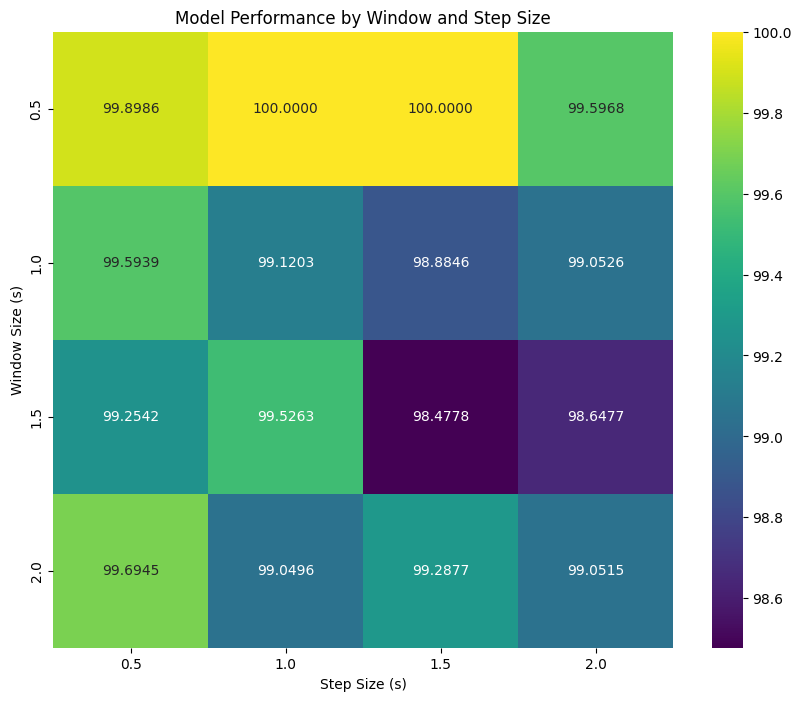

In [123]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Save results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df_results.to_csv(f'results/window_step_results_{timestamp}.csv', index=False)

# Create heatmap
plt.figure(figsize=(10, 8))
pivot_table = df_results.pivot_table(
    values='accuracy', 
    index='window_size',
    columns='step_size',
    aggfunc='mean'
)
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='viridis')
plt.title('Model Performance by Window and Step Size')
plt.xlabel('Step Size (s)')
plt.ylabel('Window Size (s)')
plt.savefig(f'results/heatmap_{timestamp}.png')
plt.show()

In [30]:
# all_labels = []
# all_predictions = []

# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to GPU
#         outputs = model(X_batch)
#         _, predicted = torch.max(outputs, 1)


#         all_labels.extend(y_batch.cpu().numpy())
#         all_predictions.extend(predicted.cpu().numpy())

# labels = np.unique(all_labels)  
# unmap_labels = [reverse_mapping[label] for label in labels]
# target_names = [f"{label}" for label in unmap_labels]

# print(classification_report(all_labels, all_predictions, target_names=target_names, labels=labels))

              precision    recall  f1-score   support

         0.5       0.88      0.96      0.91       112
        0.75       0.92      0.95      0.94       126
         1.0       0.97      0.93      0.95       121
        1.25       0.99      0.92      0.96       132

    accuracy                           0.94       491
   macro avg       0.94      0.94      0.94       491
weighted avg       0.94      0.94      0.94       491



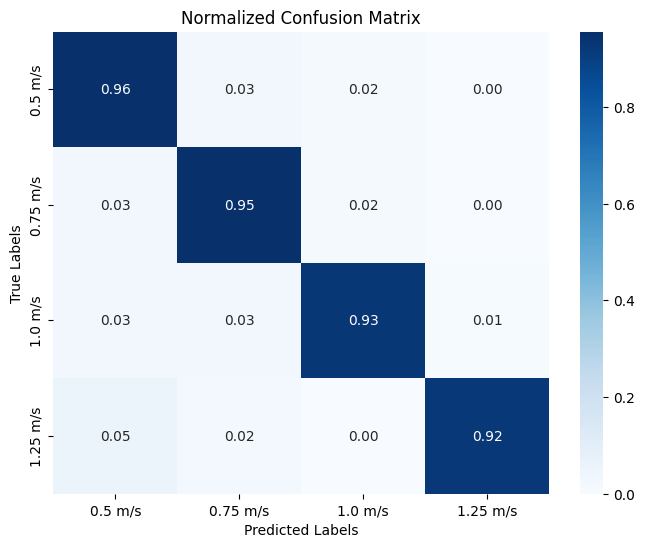

In [28]:
# conf_matrix = confusion_matrix(all_labels, all_predictions)

# class_names = ["0.5 m/s", "0.75 m/s", "1.0 m/s", "1.25 m/s"]

# conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# # Plot the heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# # Add labels and title
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Normalized Confusion Matrix')
# plt.show()


<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jirui\AppData\Local\Temp\ipykernel_29644\1543327011.py:7: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(data_root, sep='\s+')


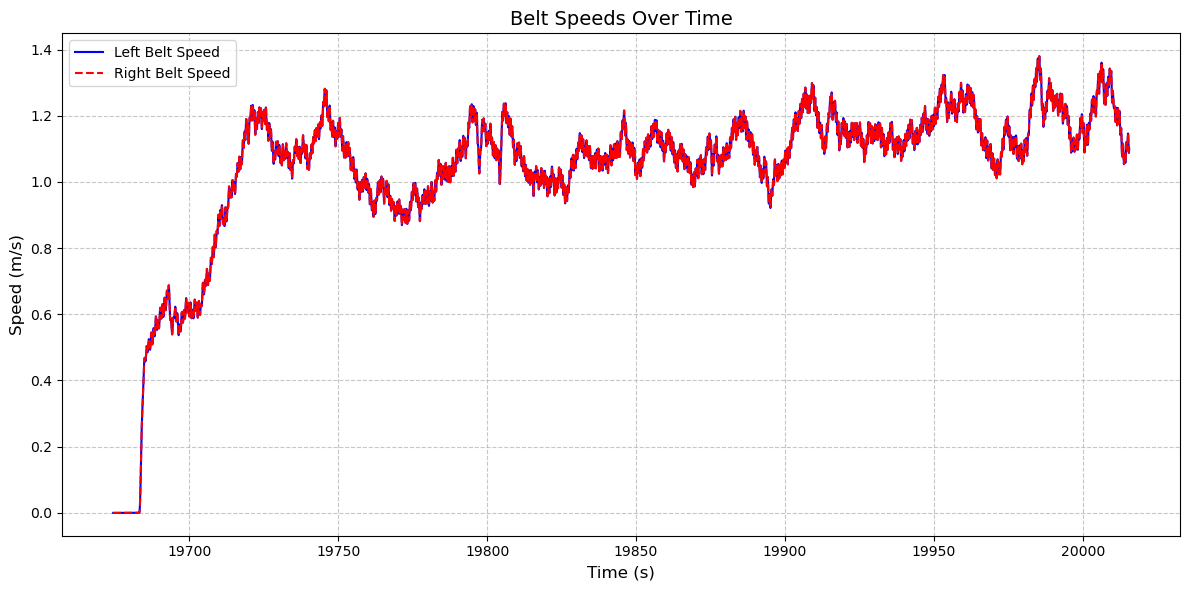

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data_root = r"C:\\Users\\jirui\\Github\\EEG_Biomechanics_Project\\1D_speed_prediction\\Ll01\D-Flow\\Ll01_level_selfpaced_treadmill0001.txt"
data = pd.read_csv(data_root, sep='\s+')
data.head()
time = data["Time"]
v_l = data["Left"]
v_r = data["Right"]
# For more customization:
plt.figure(figsize=(12, 6))
sns.lineplot(x=time, y=v_l, label='Left Belt Speed', color='blue', linestyle='-')
sns.lineplot(x=time, y=v_r, label='Right Belt Speed', color='red', linestyle='--')

# Customize the plot
plt.title('Self-paced speed', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid
plt.legend(fontsize=10)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()